This example conducts an analysis of the initial optwrf database in an attempt to tease out relationships among the different parameters.

Last Updated by Jeffrey Sward on Sept 23, 2020.

In [1]:
import csv
import datetime
import math
import random
import sys
import time

import shap
import seaborn as sns
import pandas as pd
#import prince
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from optwrf.wrfparams import num2name
from optwrf.helper_functions import date2season
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Read in the optwrf csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
# data = pd.read_csv('./optwrf_database_090820.csv')
data = pd.read_csv('./db_snapshots/optwrf_database_FINAL_exp02.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
data['fitness'].values[data['fitness'] > 1 * 10 ** 23] = np.nan
data['ghi_error'].values[data['ghi_error'] > 1 * 10 ** 23] = np.nan
data['wpd_error'].values[data['wpd_error'] > 1 * 10 ** 23] = np.nan
# Determine the season
data['season'] = [date2season(dat) for dat in data.start_date]
data.sort_values(by='fitness').iloc[:5,:]


The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,ghi_error,wpd_error,runtime,season
1383,2011-12-12,13,1,4,7,8,99,1,826.215530,0.00,1958643.62,00h 00m 00s,winter
1394,2011-09-16,19,1,4,7,8,99,1,878.756278,4.95,2073447.00,00h 00m 00s,fall
1400,2011-06-23,19,1,3,7,8,99,1,1433.182603,395.09,2460955.00,00h 00m 00s,summer
1320,2011-08-25,14,1,5,7,7,14,1,1781.050353,90.86,4029872.00,00h 00m 00s,summer
1823,2011-12-13,19,4,4,7,8,99,1,7858.155964,5905.98,9890490.00,00h 47m 53s,winter


## Random Forest Model

In this section, I train a random forest regression model to compare the relative feature importances. 

In [3]:
# Drop the start_date variable to train the random forest regressor
RFfeatures = data[['mp_physics', 'ra_lw_physics', 'ra_sw_physics', 
                  'sf_surface_physics', 'bl_pbl_physics', 'cu_physics', 
                  'wpd_error']]

# Drop rows where there are NaN values
RFfeatures = RFfeatures.dropna()

# Convert param_ids back to names so the RF algorithm will recognize them as separe categories
RFfeatures['mp_physics'] = num2name(RFfeatures.mp_physics, 'microphysics')
RFfeatures['ra_lw_physics'] = num2name(RFfeatures.ra_lw_physics, 'lw radiation')
RFfeatures['ra_sw_physics'] = num2name(RFfeatures.ra_sw_physics, 'sw radiation')
RFfeatures['sf_surface_physics'] = num2name(RFfeatures.sf_surface_physics, 'land surface')
RFfeatures['bl_pbl_physics'] = num2name(RFfeatures.bl_pbl_physics, 'PBL')
RFfeatures['cu_physics'] = num2name(RFfeatures.cu_physics, 'cumulus')
RFfeatures

,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,wpd_error
0,lin,new goddard,gfdl,noah,qnse,new tiedtke,56780220.0
1,p3 2mom,rrtm,flg,5 layer,shin-hong,kain-fritsch,41989356.0
2,sbu-ylin,cam,cam,pleim-xiu,gbm,mod kain-fritsch,30784876.0
3,nssl 2mom,cam,goddard,noah-mp,gbm,new tiedtke,13254863.0
4,wsm3,held-suarez,flg,pleim-xiu,myj,tiedtke,64502156.0
...,...,...,...,...,...,...,...
2314,thompson,rrtmg,cam,pleim-xiu,boulac,kain-fritsch,19815792.0
2315,thompson,rrtmg,cam,noah-mp,boulac,kain-fritsch,23585738.0
2316,nssl 1mom,rrtmg,dudia,pleim-xiu,boulac,old kain-fritsch,34167136.0
2317,thompson,rrtmg,dudia,pleim-xiu,boulac,kain-fritsch,13749760.0


In [4]:
# One-hot encode the data using pandas get_dummies
RFfeatures = pd.get_dummies(RFfeatures)
RFfeatures.iloc[:5,:]

,wpd_error,mp_physics_cam5.1,mp_physics_eta,mp_physics_goddard,mp_physics_kressler,mp_physics_lin,mp_physics_milbrandt2mom,mp_physics_morrison2mom,mp_physics_nssl 1mom,mp_physics_nssl 1mom lfo,...,cu_physics_grell3d,cu_physics_hwrf gfs sas,cu_physics_kain-fritsch,cu_physics_mod kain-fritsch,cu_physics_multi kain-fritsch,cu_physics_new tiedtke,cu_physics_old kain-fritsch,cu_physics_tiedtke,cu_physics_ysu gfs sas,cu_physics_zhang-mcfarlane
0,56780220.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,41989356.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,30784876.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,13254863.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,64502156.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Labels are the values we want to predict
labels = RFfeatures['wpd_error']

# Remove the labels from the features
RFfeatures = RFfeatures.drop(['wpd_error'], axis = 1)
feature_names = list(RFfeatures.columns)

# Train the Random Forest Regressor model
model = RandomForestRegressor()
model.fit(RFfeatures, labels)
# print(model.feature_importances_)

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

# SHAP TreeExplainer

SHAP values represent a feature's contribution to a change in the model ouput. In contrast to the feature importances shown above which give a relative importance and are therefore comparative, SHAP values reveal if each feature pushes model output higher or lower, so therefore can be summed -- revealing the contribution that a group of features have on model output as well. 

In [6]:
# load JS visualization code to notebook
shap.initjs()

In [7]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
try:
    shap_values = explainer.shap_values(RFfeatures)
except:
    print('Warning: bypassing the SHPA addititvity check')
    shap_values = explainer.shap_values(RFfeatures, check_additivity=False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


# Summary Plots
## Process the SHAP data for plotting in seaborn

In [8]:
# Create a pandas DataFrame to organize the shapley values -- this requires a multiindex 
# as I care about keeping track of unique models and different physics schemes.
# shap_data = xr.DataArray(shap_values, dims=("wrf_physics", "scheme"), coords={"scheme": feature_names})
shap_data = pd.DataFrame(shap_values, columns=feature_names)
shap_data

,mp_physics_cam5.1,mp_physics_eta,mp_physics_goddard,mp_physics_kressler,mp_physics_lin,mp_physics_milbrandt2mom,mp_physics_morrison2mom,mp_physics_nssl 1mom,mp_physics_nssl 1mom lfo,mp_physics_nssl 2mom,...,cu_physics_grell3d,cu_physics_hwrf gfs sas,cu_physics_kain-fritsch,cu_physics_mod kain-fritsch,cu_physics_multi kain-fritsch,cu_physics_new tiedtke,cu_physics_old kain-fritsch,cu_physics_tiedtke,cu_physics_ysu gfs sas,cu_physics_zhang-mcfarlane
0,-27512.726353,19745.057988,-648.773882,-366822.308702,2.652482e+06,-27269.193957,-34002.256998,-3.220967e+05,62890.740379,-7.229603e+04,...,4615.192110,-6.220702e+04,-7.267188e+04,-1.463228e+05,46405.713041,1.131648e+06,-3.639192e+03,-150307.512946,105458.397473,-47808.368174
1,-32100.630346,26723.796750,-9157.844614,-104947.860939,-6.957838e+04,-70288.723726,-47982.200846,1.526867e+04,36132.459086,-9.451626e+04,...,30728.279950,-1.122463e+05,1.051941e+05,-6.994882e+04,6768.145906,-5.204267e+05,3.565833e+05,-262702.908664,102163.057899,-212339.924071
2,-77839.137365,19924.084091,-1798.958528,-84473.005433,-7.240637e+03,-26335.109042,36517.303229,-3.653493e+05,-63427.832273,-3.376276e+04,...,-20129.693629,-2.363163e+05,-4.718870e+04,1.406420e+06,-127721.019526,1.545418e+03,-2.995076e+04,-35297.292817,-3226.102086,-230029.576044
3,-69560.514747,19034.142590,-2185.226746,-74012.130353,2.379579e+04,-32686.245370,-121778.500335,-2.934165e+02,-291361.872441,2.280486e+06,...,5338.383007,-1.124968e+06,-1.287358e+05,-6.117458e+04,-101213.134226,1.426733e+06,-1.392541e+05,-98523.330551,-62933.358654,-172676.626746
4,-133516.480663,55386.670747,-621.240352,-73305.436844,3.987131e+02,-10999.278295,-24272.795695,-1.084523e+05,-26290.753695,-1.391118e+04,...,25244.267941,-1.183837e+05,-3.527441e+05,-2.743210e+05,-44630.137048,-5.433717e+04,-2.300170e+06,477044.992722,6664.954894,-76121.372226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,-31841.327028,1577.857226,-677.306675,-34375.301509,5.960056e+03,-10276.869972,-22318.143871,3.270343e+05,-57600.565356,-2.778863e+04,...,26855.622946,-8.553351e+04,7.553817e+05,-3.217821e+04,-40753.542147,-7.454079e+03,1.584985e+05,-46372.967854,-38389.109799,-57678.952017
1823,-36494.630647,4060.624897,-723.161005,-32326.724336,-5.622148e+04,-11759.320824,-88385.863820,5.752238e+05,-64172.872430,1.450523e+04,...,158643.490393,-6.345681e+04,1.517306e+06,-1.118185e+04,-36941.994998,-3.311776e+04,-3.462935e+04,-40476.589811,-65456.743997,-58022.523175
1824,-15795.640726,3160.688159,-267.883647,-56981.702771,-1.381632e+04,-8914.476454,-29701.479782,1.216760e+06,-23206.643248,-1.623788e+04,...,8741.571114,-5.878005e+04,4.958948e+04,-2.641567e+04,-34366.901452,-9.294761e+03,1.378256e+06,-8844.163104,-42094.520410,-53184.399997
1825,-20170.676445,2529.997170,-379.890995,-34222.888832,1.051890e+04,-8613.107154,-22160.968619,-1.380365e+05,-35586.443926,-1.820896e+04,...,11959.274604,-5.615189e+04,8.033985e+04,-2.736518e+04,-45545.472643,-1.094886e+04,-7.317223e+05,-27353.111829,-49701.042288,-55798.431646


In [9]:
# Format the data into a more convenient pandas DataFrame
midx = pd.MultiIndex.from_product([shap_data.index, shap_data.columns], names=('model_num', 'scheme_name'))
optwrf_data = pd.DataFrame(shap_data.stack(), index=midx, columns=['shap_values'])
RFfeatures = RFfeatures.reset_index()
RFfeatures = RFfeatures.drop(['index'], axis = 1)
df = pd.DataFrame(RFfeatures.stack(), index=midx, columns=['scheme_status'])
optwrf_data = optwrf_data.join(df, ['model_num', 'scheme_name'])
optwrf_data = optwrf_data.reset_index()
optwrf_data['scheme_name_short'] = optwrf_data.scheme_name.str.split('_').str[-1]
optwrf_data

,model_num,scheme_name,shap_values,scheme_status,scheme_name_short
0,0,mp_physics_cam5.1,-2.751273e+04,0,cam5.1
1,0,mp_physics_eta,1.974506e+04,0,eta
2,0,mp_physics_goddard,-6.487739e+02,0,goddard
3,0,mp_physics_kressler,-3.668223e+05,0,kressler
4,0,mp_physics_lin,2.652482e+06,1,lin
...,...,...,...,...,...
116923,1826,cu_physics_new tiedtke,-1.094886e+04,0,new tiedtke
116924,1826,cu_physics_old kain-fritsch,-7.317223e+05,0,old kain-fritsch
116925,1826,cu_physics_tiedtke,-2.735311e+04,0,tiedtke
116926,1826,cu_physics_ysu gfs sas,-4.970104e+04,0,ysu gfs sas


In [10]:
# Change the scheme_status variable to strings for plotting
# [1 if x > 0 else 0 for x in l]
optwrf_data['scheme_status'] = ['On' if status == 1 else 'Off' for status in optwrf_data.scheme_status]

In [11]:
# Isolate the physics being parameterized
physics = optwrf_data.scheme_name.str.split('_').str[0]
# Subset the optwrf data by physics parameterization
mp_shap = optwrf_data[physics == 'mp']
ra_shap = optwrf_data[physics == 'ra']
sf_shap = optwrf_data[physics == 'sf']
bl_shap = optwrf_data[physics == 'bl']
cu_shap = optwrf_data[physics == 'cu']

In [12]:
ra_shap

,model_num,scheme_name,shap_values,scheme_status,scheme_name_short
21,0,ra_lw_physics_cam,59863.907062,Off,cam
22,0,ra_lw_physics_flg,311606.687860,Off,flg
23,0,ra_lw_physics_gfdl,-52846.592441,Off,gfdl
24,0,ra_lw_physics_held-suarez,-612434.449227,Off,held-suarez
25,0,ra_lw_physics_new goddard,4758.332245,On,new goddard
...,...,...,...,...,...
116894,1826,ra_sw_physics_flg,-27554.612173,Off,flg
116895,1826,ra_sw_physics_gfdl,-58727.609156,Off,gfdl
116896,1826,ra_sw_physics_goddard,-4556.801905,Off,goddard
116897,1826,ra_sw_physics_new goddard,129987.570962,Off,new goddard


In [13]:
def physics_shap_catplot(catplot_data, xdata='shap_values', ydata='scheme_name_short', 
                         plot_type='strip', ylabels=None, save_fig=False, fig_name=None, **kwargs):
    """
    Draws a seaborn catplot for one of the physics categories (MP, RA, BL, SF, CU)
    """
    sns.set_context('paper')
    sns.set_theme(style='ticks')
    if 'split' in kwargs:
        catplt = sns.catplot(x=xdata, y=ydata, data=catplot_data, hue='scheme_status', 
                kind=plot_type, height=8.27, aspect=11.7/8.27, legend_out=False, split=kwargs.get('split'))
    else:
        catplt = sns.catplot(x=xdata, y=ydata, data=catplot_data, hue='scheme_status', 
                kind=plot_type, height=8.27, aspect=11.7/8.27, legend_out=False)
    # Tweak the visual presentation...
    plt.axvline(0, 0, 1, c='black', lw=1, ls='-')
    catplt._legend.set_title("Scheme Status")
    catplt.despine(top=False, right=False)
    # Format the axes
    for ax in catplt.axes.flat:
        for label in ax.get_xticklabels():
            label.set_fontsize(14)
        for label in ax.get_yticklabels():
            label.set_fontsize(14)
    #     ax.xaxis.grid(True)
        ax.set_xlabel("Influence on WPD Error (SHAP Values)\n ← Lower Error       Higher Error  →", fontsize=16)
        if ylabels is not None:
            ax.set_yticklabels(ylabels)
        ax.set_ylabel("")
        ax.set(xlim=(-catplot_data.shap_values.max()/10, catplot_data.shap_values.max()/10))
    # Save the figure
    if save_fig is True:
        if fig_name is not None:
            catplt.savefig(fig_name, dpi=300)
        else:
            path = '/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/shap_plots/'
            catplt.savefig(path + 'physics_shap_catplot.png', dpi=300)

## Effect of Radiation Schemes on WPD Error

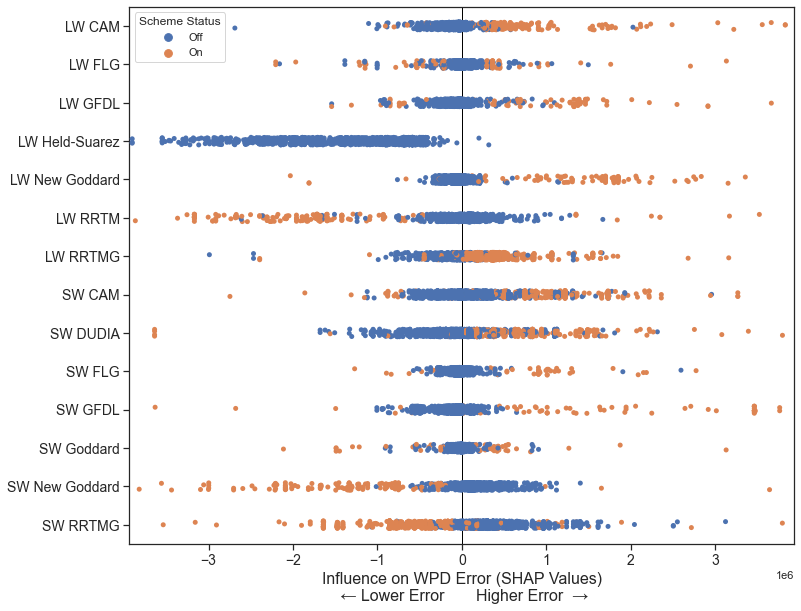

In [14]:
ylabs = ['LW CAM', 'LW FLG', 'LW GFDL', 'LW Held-Suarez', 'LW New Goddard', 'LW RRTM', 'LW RRTMG', 
         'SW CAM', 'SW DUDIA', 'SW FLG', 'SW GFDL', 'SW Goddard', 'SW New Goddard', 'SW RRTMG']
fig_path = '/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/shap_plots/'
fig_name = fig_path + 'RA_WPD_catplot_dots.png'
physics_shap_catplot(ra_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='strip', ylabels=ylabs, save_fig=True, fig_name=fig_name)

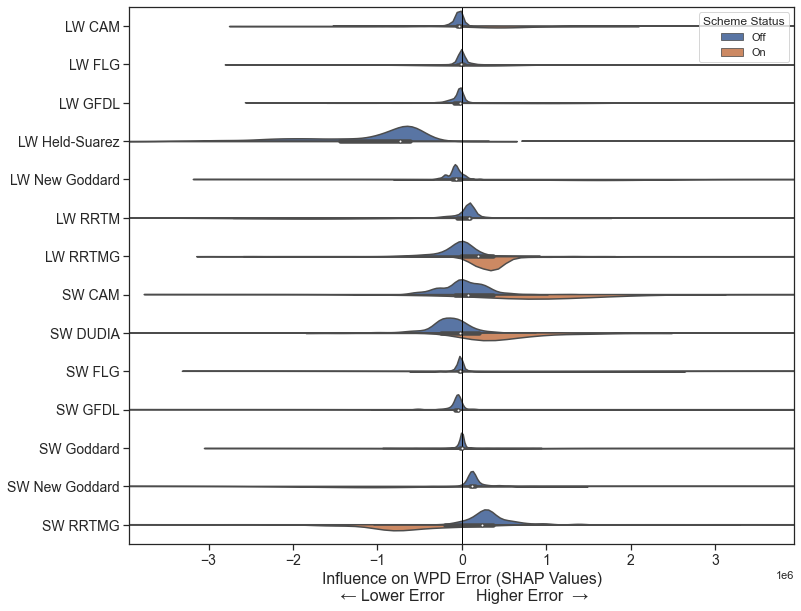

In [15]:
fig_name = fig_path + 'RA_WPD_catplot_violin.png'
physics_shap_catplot(ra_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='violin', ylabels=ylabs, split=True, save_fig=True, fig_name=fig_name)

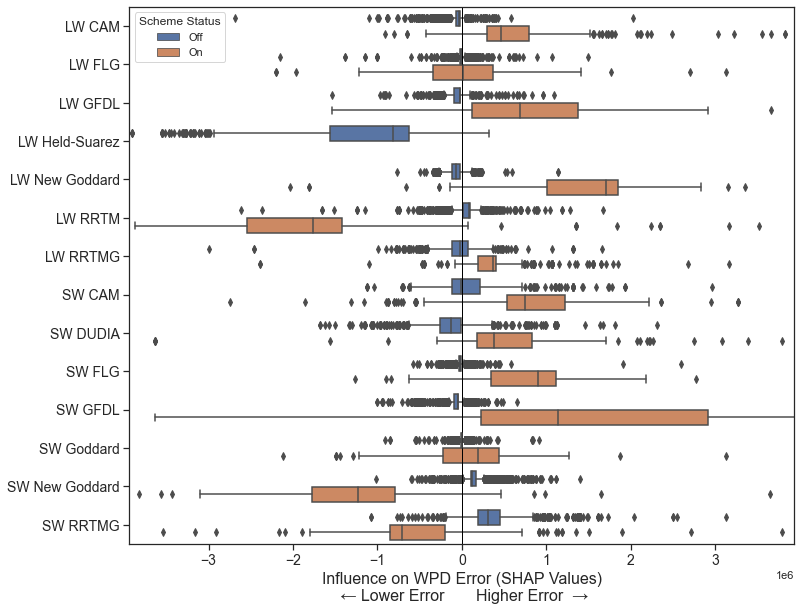

In [16]:
fig_name = fig_path + 'RA_WPD_catplot_boxplot.png'
physics_shap_catplot(ra_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='box', ylabels=ylabs, save_fig=True, fig_name=fig_name)

## Effect of PBL Schemes on WPD Error

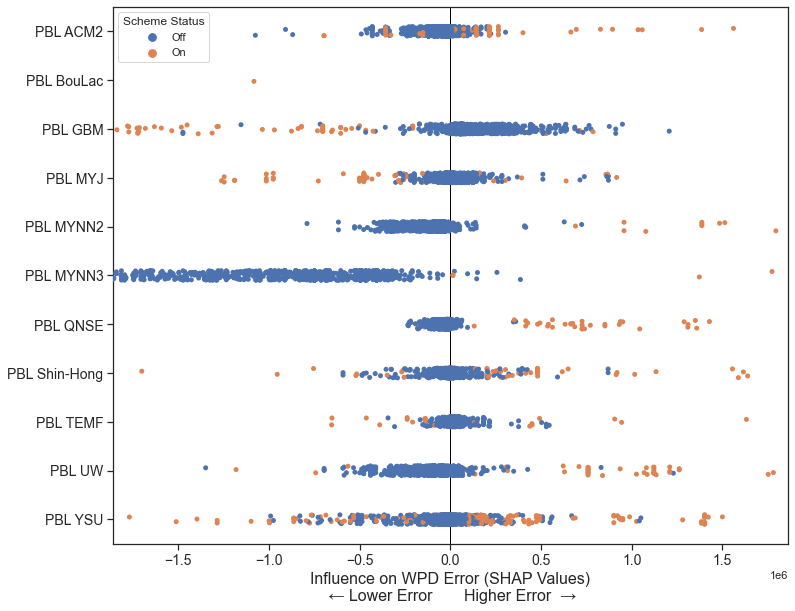

In [17]:
ylabs = ['PBL ACM2', 'PBL BouLac', 'PBL GBM', 'PBL MYJ', 'PBL MYNN2', 'PBL MYNN3', 'PBL QNSE', 
         'PBL Shin-Hong', 'PBL TEMF', 'PBL UW', 'PBL YSU']
fig_name = fig_path + 'PBL_WPD_catplot_dots.png'
physics_shap_catplot(bl_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='strip', ylabels=ylabs, save_fig=True, fig_name=fig_name)

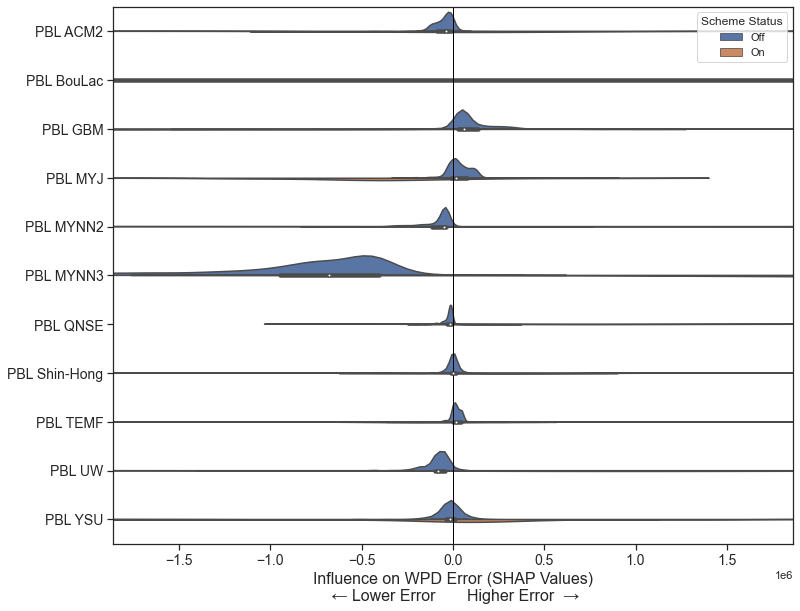

In [18]:
fig_name = fig_path + 'PBL_WPD_catplot_violin.png'
physics_shap_catplot(bl_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='violin', ylabels=ylabs, split=True, save_fig=True, fig_name=fig_name)

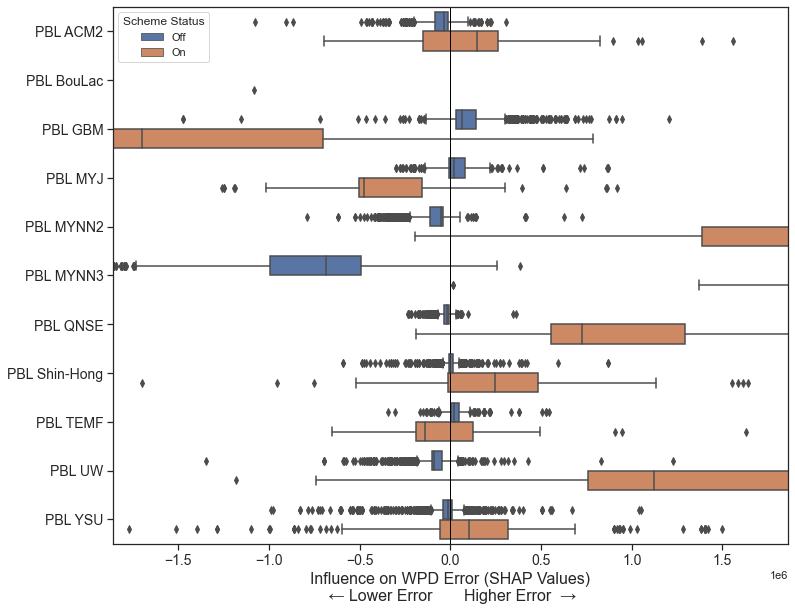

In [19]:
fig_name = fig_path + 'PBL_WPD_catplot_boxplot.png'
physics_shap_catplot(bl_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='box', ylabels=ylabs, save_fig=True, fig_name=fig_name)

## Effect of Microphysics Schemes on WPD Error

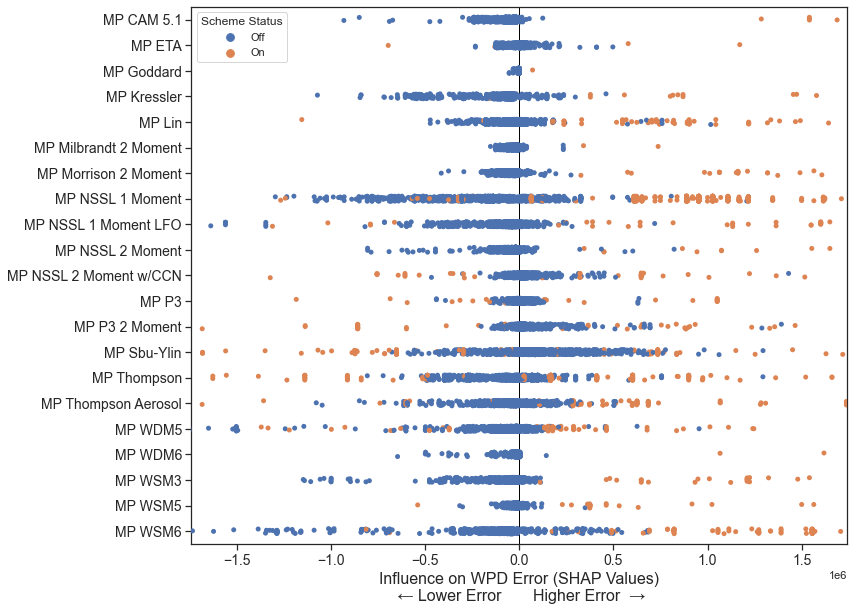

In [21]:
ylabs = ['MP CAM 5.1', 'MP ETA', 'MP Goddard', 'MP Kressler', 'MP Lin', 'MP Milbrandt 2 Moment', 'MP Morrison 2 Moment', 
         'MP NSSL 1 Moment', 'MP NSSL 1 Moment LFO', 'MP NSSL 2 Moment', 'MP NSSL 2 Moment w/CCN', 'MP P3', 
         'MP P3 2 Moment', 'MP Sbu-Ylin', 'MP Thompson', 'MP Thompson Aerosol', 'MP WDM5', 'MP WDM6', 'MP WSM3', 'MP WSM5',
         'MP WSM6']
fig_name = fig_path + 'MP_WPD_catplot_dots.png'
physics_shap_catplot(mp_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='strip', ylabels=ylabs, save_fig=True, fig_name=fig_name)

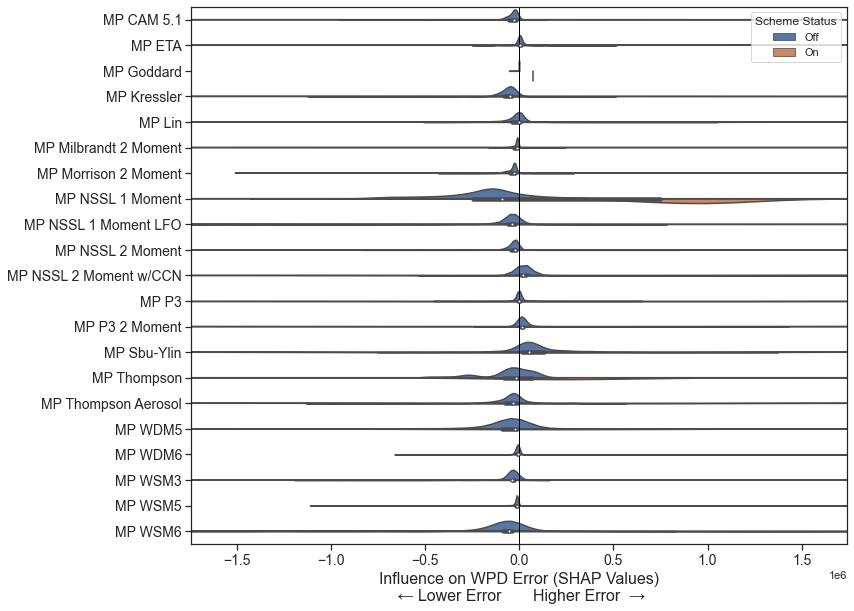

In [22]:
fig_name = fig_path + 'MP_WPD_catplot_violin.png'
physics_shap_catplot(mp_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='violin', ylabels=ylabs, split=True, save_fig=True, fig_name=fig_name)

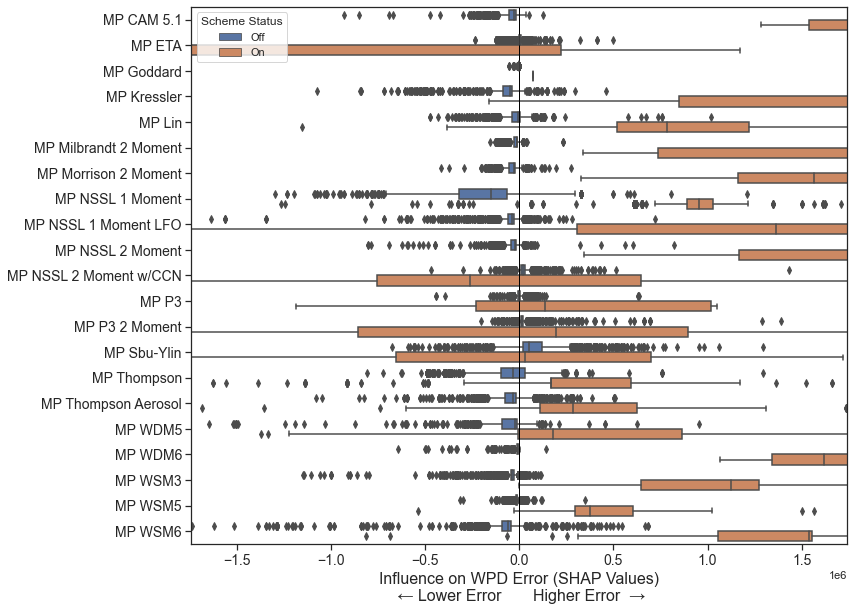

In [23]:
fig_name = fig_path + 'MP_WPD_catplot_boxplot.png'
physics_shap_catplot(mp_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='box', ylabels=ylabs, save_fig=True, fig_name=fig_name)

## Effect of Land Surface Schemes on WPD Error

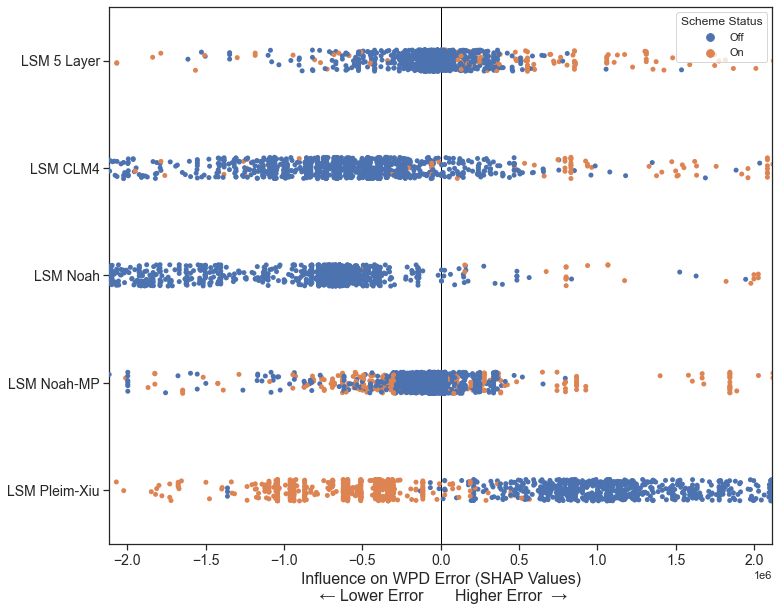

In [24]:
ylabs = ['LSM 5 Layer', 'LSM CLM4', 'LSM Noah', 'LSM Noah-MP', 'LSM Pleim-Xiu']
fig_name = fig_path + 'LSM_WPD_catplot_dots.png'
physics_shap_catplot(sf_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='strip', ylabels=ylabs, save_fig=True, fig_name=fig_name)

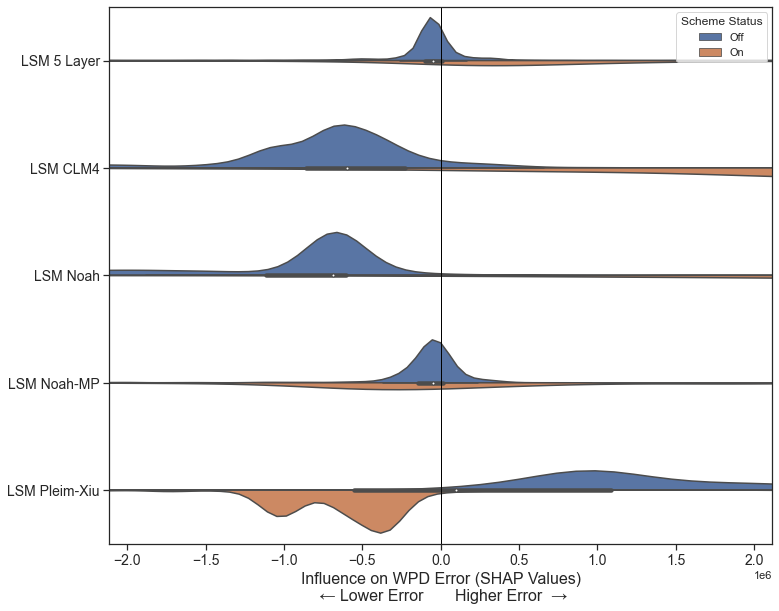

In [25]:
fig_name = fig_path + 'LSM_WPD_catplot_violin.png'
physics_shap_catplot(sf_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='violin', ylabels=ylabs, split=True, save_fig=True, fig_name=fig_name)

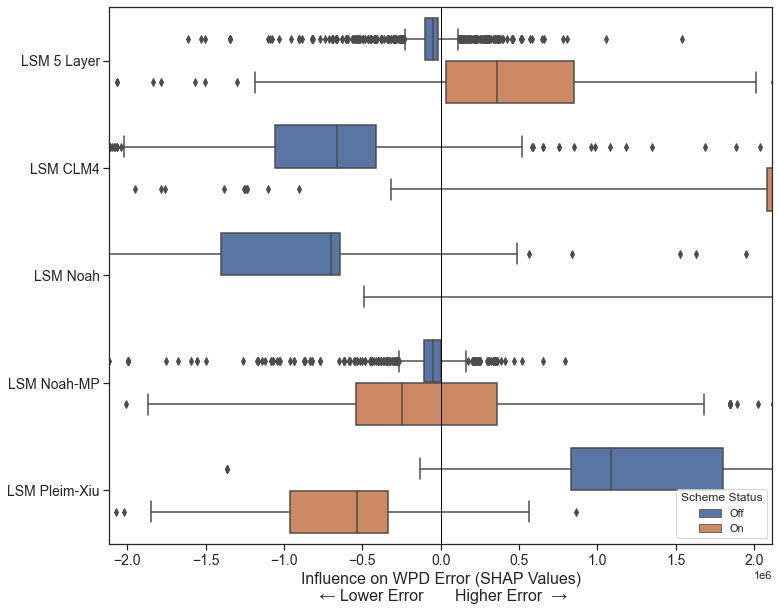

In [26]:
fig_name = fig_path + 'LSM_WPD_catplot_boxplot.png'
physics_shap_catplot(sf_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='box', ylabels=ylabs, save_fig=True, fig_name=fig_name)

## Effect of Cumulus Schemes on WPD Error

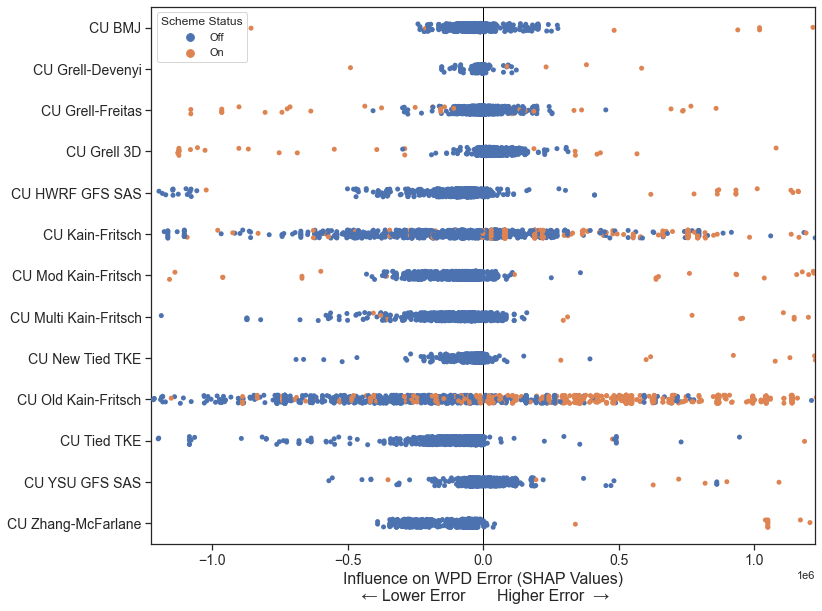

In [27]:
ylabs = ['CU BMJ', 'CU Grell-Devenyi', 'CU Grell-Freitas', 'CU Grell 3D', 'CU HWRF GFS SAS', 'CU Kain-Fritsch',
         'CU Mod Kain-Fritsch', 'CU Multi Kain-Fritsch', 'CU New Tied TKE', 'CU Old Kain-Fritsch', 'CU Tied TKE',
         'CU YSU GFS SAS', 'CU Zhang-McFarlane']
fig_name = fig_path + 'CU_WPD_catplot_dots.png'
physics_shap_catplot(cu_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='strip', ylabels=ylabs, save_fig=True, fig_name=fig_name)

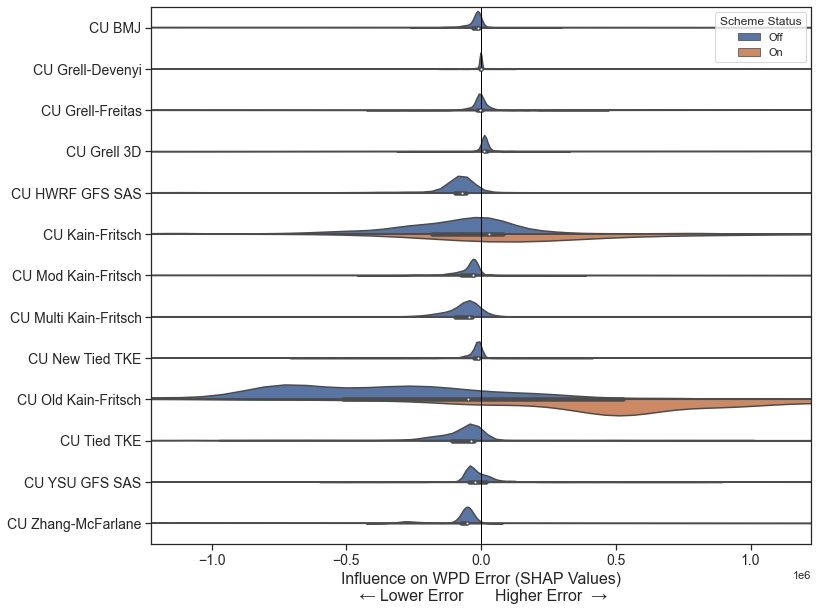

In [28]:
fig_name = fig_path + 'CU_WPD_catplot_violin.png'
physics_shap_catplot(cu_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='violin', ylabels=ylabs, split=True, save_fig=True, fig_name=fig_name)

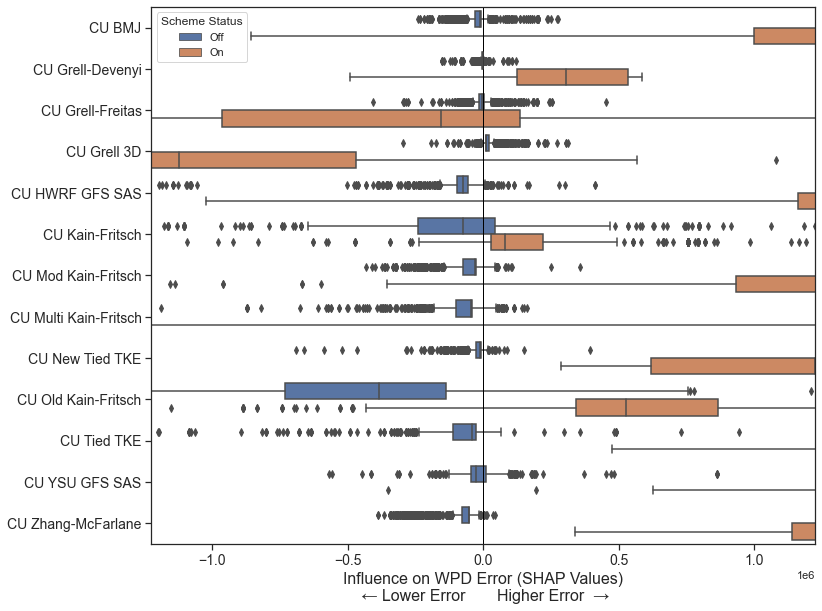

In [29]:
fig_name = fig_path + 'CU_WPD_catplot_boxplot.png'
physics_shap_catplot(cu_shap, xdata='shap_values', ydata='scheme_name', 
                     plot_type='box', ylabels=ylabs, save_fig=True, fig_name=fig_name)